In [20]:
import random
import cv2
import numpy as np
import inspect
from Levenshtein import distance
from matplotlib import pyplot as plt
import pytesseract
import time
import re
from IPython.display import clear_output
from functools import wraps, WRAPPER_ASSIGNMENTS
import itertools
import json

from src.opencvfilters import OpenCVFilters

In [21]:
filters = OpenCVFilters()

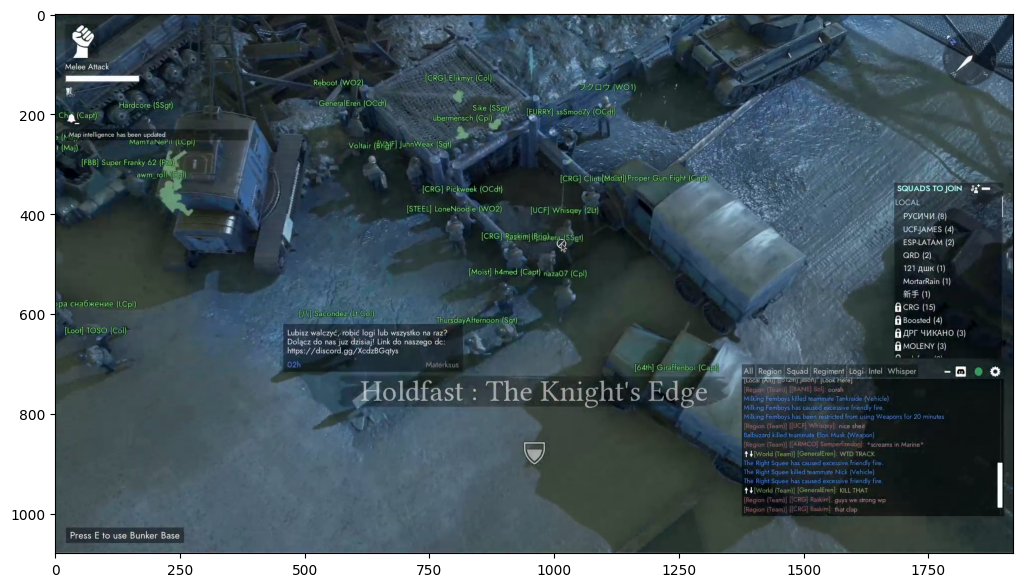

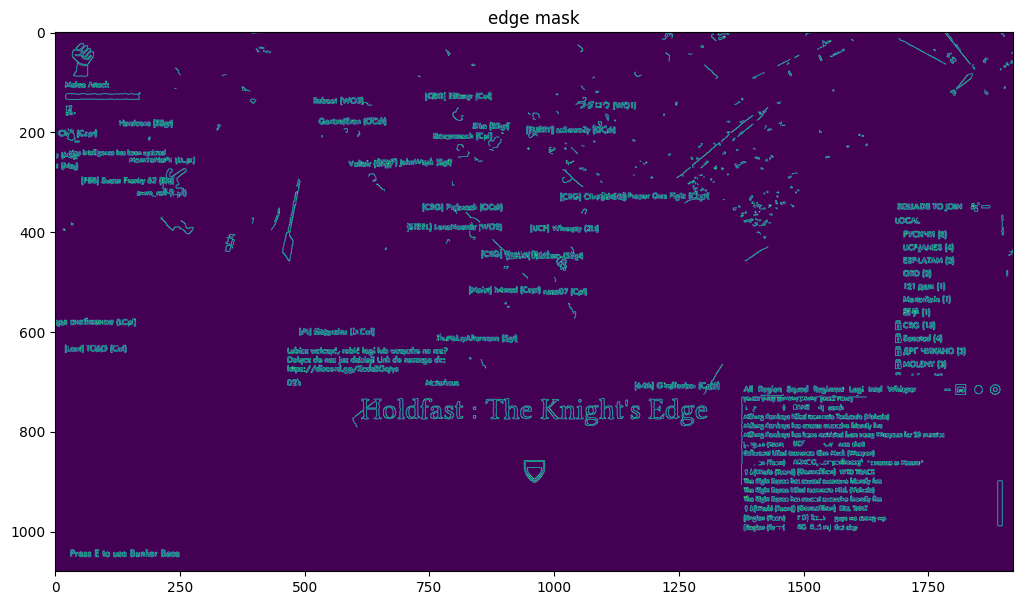

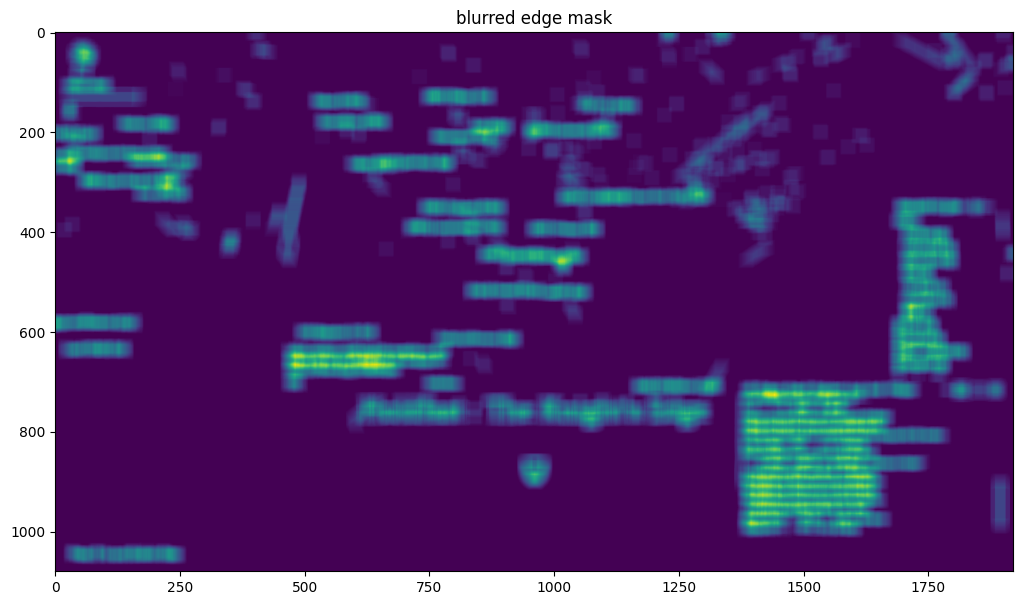

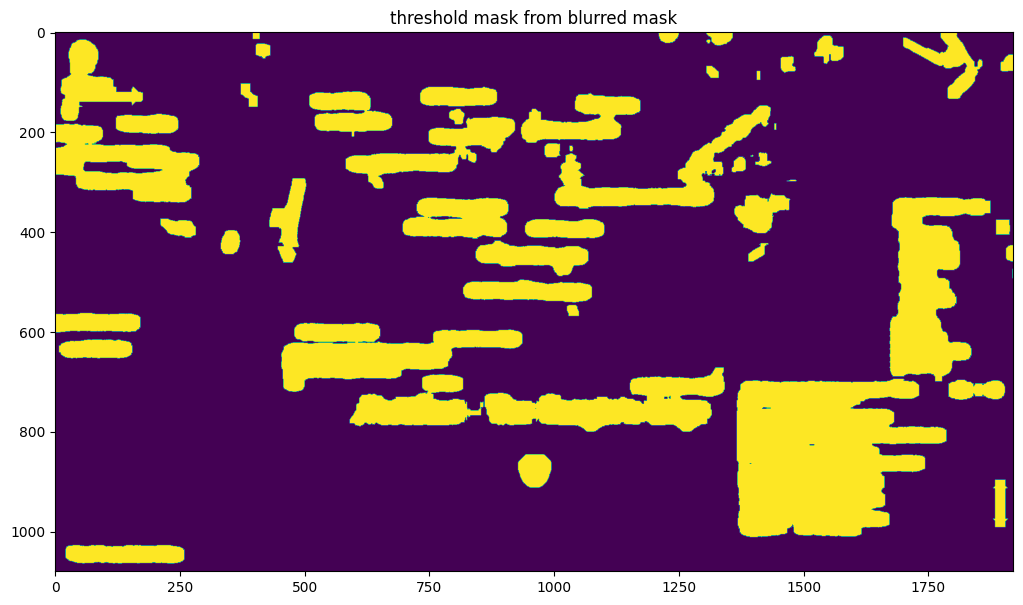

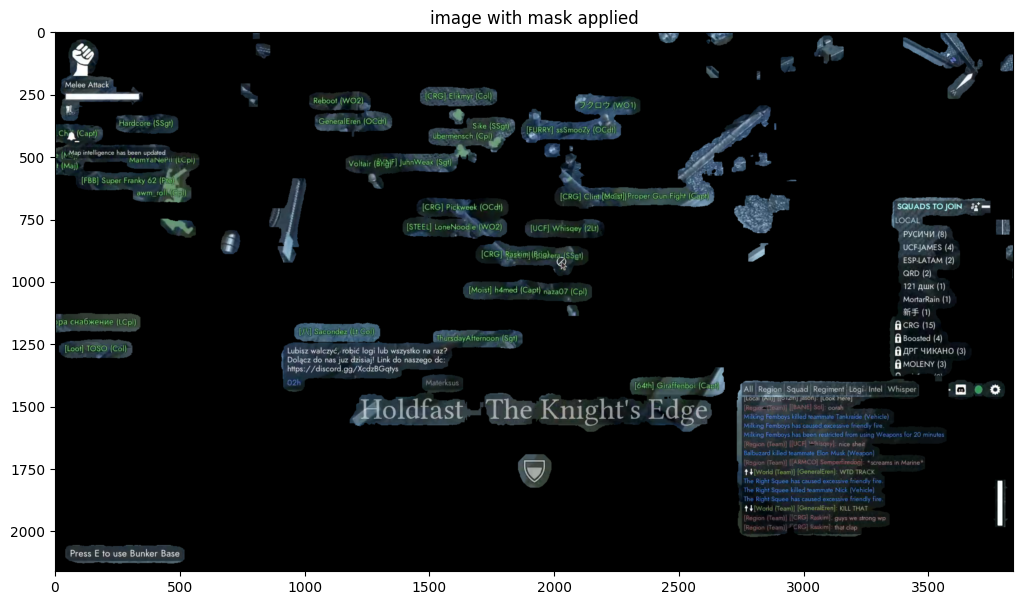

63


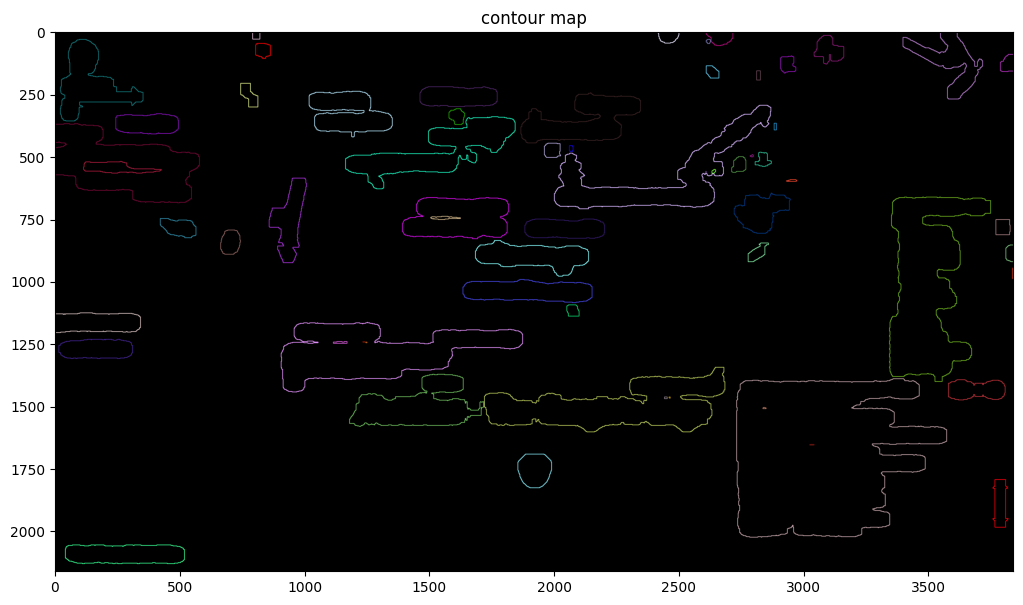

In [22]:
def show(img, title = ""):
    plt.imshow(img)
    plt.rcParams['figure.figsize'] = [15,7]
    plt.title(title)
    plt.show()

img = cv2.imread("manynames.png")
show(img)
brightness = 128
contrast = 50


new_img = img
mask = img
new_img, mask = filters.make_edge_mask(new_img,mask,50,100)
show(mask, "edge mask")
new_img, mask = filters.blur_mask(new_img,mask)#,30,30)
show(mask, "blurred edge mask")
new_img, mask = filters.threshold_mask_from_mask(new_img,mask)#,10,255)
show(mask, "threshold mask from blurred mask")
new_img, mask = filters.apply_mask(new_img,mask)
new_img, mask = filters.resize_image_and_mask(new_img,mask)
show(new_img, "image with mask applied")

cv2.imwrite("masked.png", mask)
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

drawing = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
    color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
    cv2.drawContours(drawing, contours, i, color, 2, cv2.LINE_8, hierarchy, 0)
    
show(drawing, "contour map")

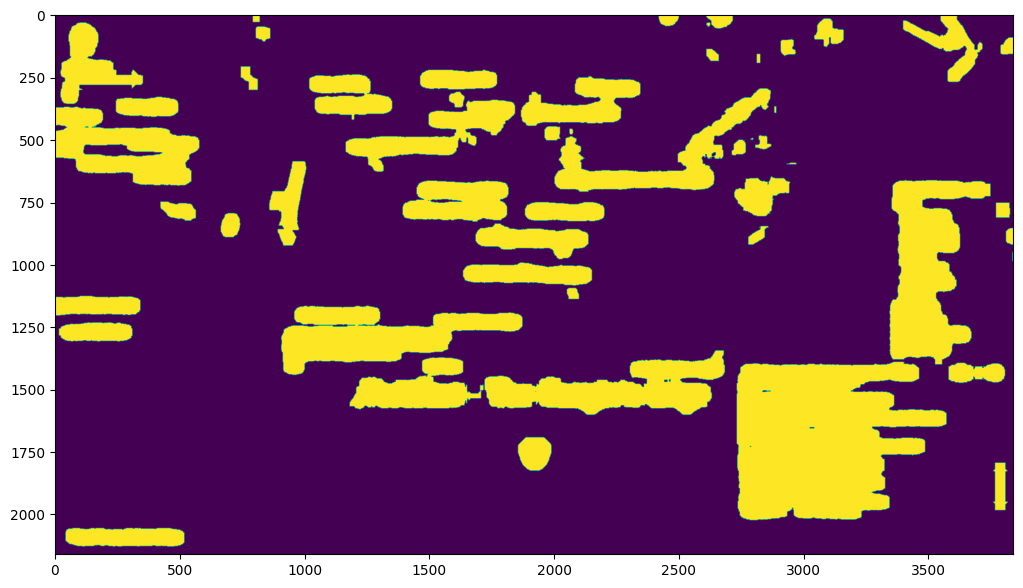

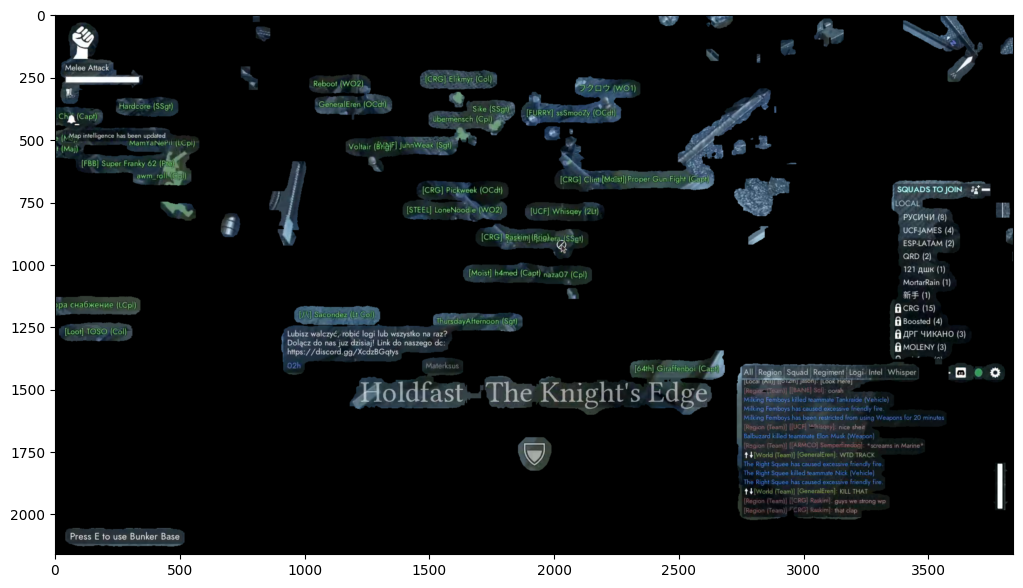

In [23]:
def get_text_from_rectangle(img):
    text = pytesseract.image_to_string(img, config =f'--oem 1 --psm 7 -c load_system_dawg=false -c load_freq_dawg=false')
    return text

def get_rectangle_from_contour(img, contour):
    x,y,w,h = cv2.boundingRect(contour)
    roi = new_img[y:y+h, x:x+w]
    return roi

rb = []

for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    if w > 150:
        rect = get_rectangle_from_contour(img, c)
        text = get_text_from_rectangle(rect)
        #show(rect, text)
        if "Cee" in text:
            rb.append(rect)

def mask_to_bounding_boxes(mask, min_width=150, max_width=700, min_height=20, max_height=500):
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        if (w > min_width) and (w < max_width) and (h>min_height) and (h<max_height):
            boxes.append({"y1": y,
                          "y2": y+h,
                          "x1": x,
                          "x2": x+w})
    return boxes
    
def get_rectangles_from_image(img, mask):
    boxes = mask_to_bounding_boxes(mask)
    rectangles = []
    for box in boxes:
        rectangles.append(img[box["y1"]:box["y2"], box["x1"]:box["x2"]])
    return rectangles

show(mask)
show(new_img)

In [15]:
def process_single(img):
    img = rb[0]
    mask = rb[0]
    
    img, mask = filters.invert_image_colours(img, mask)
    img, mask = filters.adjust_red(img, mask,128,200)
    img, mask = filters.adjust_green(img, mask,128,200)
    img, mask = filters.adjust_blue(img, mask,128,200)
    
    
    show(img)
    
    scrape_names(img)

In [6]:
config = filters.create_default_config(["adjust_hue",
                                        "adjust_saturation",
                                        "adjust_lightness",
                                        "make_edge_mask",
                                        "blur_mask",
                                        "threshold_mask_from_mask",
                                        "apply_mask",  
                                        "resize_image_and_mask",
                                        "make_mask_from_colour",
                                        "apply_mask",
                                        "adjust_red",
                                        "adjust_green",
                                        "adjust_blue",
                                        "invert_image_colours"
                                        ])

config = filters.create_default_config([
                                        "make_edge_mask",
                                        "blur_mask",
                                        "threshold_mask_from_mask",
                                        "apply_mask",  
                                        "resize_image_and_mask",
                                        "make_mask_from_colour",
                                        "apply_mask",
                                        "invert_image_colours",
                                        "adjust_red",
                                        "adjust_green",
                                        "adjust_blue"
                                        ])
values = filters.map_config_to_list(config)

In [7]:
def make_random_change(values_list):
    new_values = values_list[:]
    change = random.choice([-128,-64,-32,-16,-8,-4,-2,-1,1,2,4,8,16,32,64,128])
    index = random.randint(0,len(values_list)-1) # random index of value 
    new_values[index] = np.clip(values_list[index]+change, 0,255)
    return new_values


In [8]:
json_config = filters.get_config_json(config)

In [9]:
def apply_filters(img, config):
    mask = img
    for f in config:
        if f.get("values"):
            img, mask = f["function"](img, mask, **f["values"])
        else:
            img, mask = f["function"](img, mask)
    return img, mask

In [10]:
known_names = ["Hardcore", "Super Franky 62", "awm_roll", "TOSO", "Reboot", "Elikmyr", 
         "GeneralEren", "Voltair", "Sike", "ubermensch", "ssSmoozy", "JuhnWeak",
         "Voltair", "Pickweek", "Clint", "LoneNoodle", "Whisqey", "Raskim",
         "h4med", "naza07", "ThursdayAfternoon", "Sacondez", "Giraffenboi",
         "Proper Gun Fight"]

ranks = open("ranks.txt", "r").read().split("\n")
ranks = [f"({r})" for r in ranks]


def scrape_names(img, psm=11):
    valid_names = []
    #try:
        #print(f'using psm {psm}')
    if True: #try:
        text = pytesseract.image_to_string(img, config =f'--oem 1 --psm {psm} -c load_system_dawg=false -c load_freq_dawg=false')
        reg = "|".join([re.escape(f"{r}") for r in ranks])
        res = re.finditer(reg,text)
        split_points = [0] + [t.end() for t in res]
        split_on_rank = []
        for x in range(1,len(split_points)):
            split_on_rank.append(text[split_points[x-1]:split_points[x]])
        valid_names = [l.split("\n")[-1].split("]")[-1].split("(")[0].strip() for l in split_on_rank]
        return valid_names
    #except:
    #    return []

def score_results(target, results):
    total_score = 0
    for name in target:
        all_scores = [distance(name, guess) for guess in results]
        all_scores.sort()
        if all_scores:
            total_score += all_scores[0]
    return total_score

def scrape_names_via_contours(img, mask):
    rects = get_rectangles_from_image(img, mask)
    words = []
    for r in rects: 
        words = words + scrape_names(r)
    return words

In [11]:
best_score = 9999999999
best_result = []

start_values = filters.map_config_to_list(config)
best_values = start_values[:]

In [ ]:
existing_config = json.loads(open("foxhole_greentext.json", "r").read())
config = filters.populate_config_functions(existing_config)
start_values = filters.map_config_to_list(config)

print(start_values)

best_values = start_values[:]

for x in range(0, 10000):
    start_time = time.time()
    img = cv2.imread("manynames.png")
    new_values = make_random_change(best_values)
    #new_values = make_random_change(new_values)
    print(f'{x} - run with: {new_values}')
    config = filters.map_list_to_config(config, new_values)
    new_img, mask = apply_filters(img, config)
    #found_names = scrape_names(new_img)
    found_names = scrape_names_via_contours(new_img, mask)
    score = score_results(known_names, found_names)
    end_time = time.time() - start_time
    print(f'found_names: {found_names} in {end_time} seconds\n')
    if score:
        score += end_time
        if score < best_score:
            cv2.imwrite(f'snapshots/test_{x}.png', new_img)
            print(f'NEW BEST FOUND: {score}\n\n')
            best_score = score
            best_values = new_values
            best_result = found_names
            clean_config = filters.get_config_json(config)
            with open("foxhole_greentext.json", "w") as f:
                f.write(json.dumps(clean_config,indent=4))

[50, 200, 30, 30, 10, 255, 100, 100, 1, 0, 255, 0, 255, 0, 255, 128, 128, 128, 128, 128, 128]
0 - run with: [52, 200, 30, 30, 10, 255, 100, 100, 1, 0, 255, 0, 255, 0, 255, 128, 128, 128, 128, 128, 128]
found_names: [] in 0.3142886161804199 seconds

1 - run with: [50, 200, 30, 30, 10, 255, 100, 100, 1, 0, 255, 0, 255, 0, 255, 128, 128, 128, 128, 128, 128]
found_names: [] in 0.2687971591949463 seconds

2 - run with: [50, 200, 30, 30, 10, 255, 228, 100, 1, 0, 255, 0, 255, 0, 255, 128, 128, 128, 128, 128, 128]
found_names: [] in 1.3775994777679443 seconds

3 - run with: [50, 200, 30, 30, 10, 255, 100, 100, 1, 0, 255, 0, 255, 0, 255, 128, 128, 128, 112, 128, 128]
found_names: [] in 0.326951265335083 seconds

4 - run with: [50, 200, 30, 30, 10, 255, 100, 100, 129, 0, 255, 0, 255, 0, 255, 128, 128, 128, 128, 128, 128]
found_names: [] in 0.34830403327941895 seconds

5 - run with: [50, 200, 30, 30, 10, 253, 100, 100, 1, 0, 255, 0, 255, 0, 255, 128, 128, 128, 128, 128, 128]
found_names: [] in 0.

In [ ]:
existing_config = json.loads(open("foxhole_greentext.json", "r").read())
config = filters.populate_config_functions(existing_config)
print(config)
start_values = filters.map_config_to_list(config)

In [ ]:
show(new_img)

In [ ]:
img = cv2.imread("manynames.png")
new_img = apply_filters(img, config)
cv2.imwrite("test.png", new_img)